# Using statistical tests
This Notebook will show some examples of using statistical tests to get qualitative results from questions asked of the accidents dataset.

In [1]:
# Import the required libraries

import pymongo
import datetime
import collections

import pandas as pd
import scipy.stats

In [2]:
# Open a connection to the Mongo server, open the accidents database and name the collections of accidents and labels
# client = pymongo.MongoClient('mongodb://localhost:27017/')
client = pymongo.MongoClient('mongodb://localhost:27351/')

db = client.accidents
accidents = db.accidents
labels = db.labels

In [3]:
# Load the expanded names of keys and human-readable codes into memory

expanded_name = collections.defaultdict(str)
for e in labels.find({'expanded': {"$exists": True}}):
    expanded_name[e['label']] = e['expanded']
    
label_of = collections.defaultdict(str)
for l in labels.find({'codes': {"$exists": True}}):
    for c in l['codes']:
        try:
            label_of[l['label'], int(c)] = l['codes'][c]
        except ValueError: 
            label_of[l['label'], c] = l['codes'][c]

## Pearson's *R*²
### Comparing the number of casualties and vehicles
This is the same investigation as in Notebook `14.2 Introduction to accidents`.

In [4]:
# Build a DataFrame, one row for each accident
cas_veh_unrolled_df = pd.DataFrame(list(accidents.find({}, ['Number_of_Casualties', 'Number_of_Vehicles'])))

# Count the number of each severity
cas_veh_df = pd.crosstab(cas_veh_unrolled_df['Number_of_Casualties'], 
                                      cas_veh_unrolled_df['Number_of_Vehicles'])
# Reshape
cas_veh_long_df = cas_veh_df.stack().reset_index()
cas_veh_long_df

,Number_of_Casualties,Number_of_Vehicles,0
0,1,1,39217
1,1,2,65680
2,1,3,6168
3,1,4,1056
4,1,5,197
5,1,6,76
6,1,7,27
7,1,8,4
8,1,9,1
9,1,10,1


In [5]:
regressionline = scipy.stats.linregress(cas_veh_unrolled_df['Number_of_Casualties'],
                                       cas_veh_unrolled_df['Number_of_Vehicles'])

# The regression line is of the form y = m x + b
m = regressionline[0]
b = regressionline[1]
(m, b)

(0.21101011188488891, 1.542734939456031)

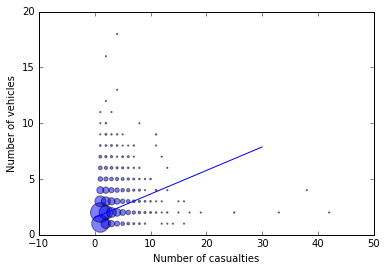

In [6]:
plt.scatter(cas_veh_long_df['Number_of_Casualties'], 
            cas_veh_long_df['Number_of_Vehicles'],
            s=np.sqrt(cas_veh_long_df[0])*1.5,
            alpha=0.5
            )

x = np.linspace(0, 30, 20)
plt.plot(x, m*x + b)

plt.xlabel('Number of casualties')
plt.ylabel('Number of vehicles')
plt.show()

The `pearsonr` function calculates Pearson's *R*² value of correlation. The function takes two lists of numbers, of equal lengths. The Pearson's *R*² function looks at the values at the same index in both lists and finds how the values in one column vary with respect to the other column. 

Note that we have to give each accident on its own row: if there are 145,000 accidents, the `pearsonr` function must be passed lists with 145,000 items.

Recall that values near +1 show good positive correlation, values near -1 show good negative correlation, and values near 0 show no particular correlation. The `scipy` function returns a second value, the *p* value of the result. 

In [7]:
scipy.stats.pearsonr(cas_veh_unrolled_df['Number_of_Casualties'], 
                     cas_veh_unrolled_df['Number_of_Vehicles'])

(0.24158490939232527, 0.0)

This result shows a small, positive correlation with a very small *p* value. In other words, there's not much correlation, and the result is statistically significant. This means we can reject the the null hypothesis that the number of casualties in an accident is unrelated to the number of vehicles.

Looking at the data, it seems to be a result that most accidents result in very few casualties, and the accidents with the most casualties have few vehicles.

Can you think of a reason for this?

You'll look at this in more detail in Notebook `14.4 Regression on subgroups`.

### Activity 1
Ages of people in the accidents dataset are stored as bands, not continuous values. This means that correlations between them must use Spearman's *r*.

Calculate the Spearman rank-order correlation coefficient between the age of a vehicle's driver and the age of the passengers. 

Similar to the Pearson function above, the `scipy.stats.spearmanr()` function takes two parameters, each a list of values for the two variables being compared. 

You'll need to create an `unrolled` DataFrame with one row for each injured passenger. Each row should have two values: one for the age band of the driver, and one for the age band of a passenger. If the vehicle has multiple passengers, the DataFrame should have one row for each passenger. (Each element of `Casualties` has a `Vehicle_Reference` that relates it to the vehicle the casualty was in.)

We're interested in the relationship between drivers and passengers, so don't include the driver as a casualty. (Use the `Casualty_Class` to find out.)

Don't include any driver-passenger pairs where the age of one of them is unknown (code -1).

**Hint**

Each accident document contains a list of vehicles and a list of casualties. For each accident, you'll need to iterate through both of these to find the information for each individual casualty.

The solution is in the [`14.3solutions`](14.3solutions.ipynb) Notebook.

In [9]:
# Insert your solution here.

## Chi-squared example 1: hypothetical voting intention
This is the same example as used in the teaching material, showing how the chi-squared statistic is calculated.

Note this way of creating a DataFrame. It's a `dict`, where each entry is a column in the DataFrame. The key is the column name, the value is the items in the column. Each set of column values is itself a `dict`, with one key for each index entry and the value being the contents of that cell in the DataFrame.

In [10]:
actual_survey_results = pd.DataFrame({'Conservative': {'Men': 170, 'Women': 220},
                      'Labour': {'Men': 240, 'Women': 190},
                      'Other': {'Men': 80, 'Women': 100}})
actual_survey_results

,Conservative,Labour,Other
Men,170,240,80
Women,220,190,100


In [11]:
expected_survey_results = pd.DataFrame({c: {r: (actual_survey_results[c].sum() * 
                                                actual_survey_results.loc[r].sum() / 
                                                actual_survey_results.sum().sum() )
                  for r in actual_survey_results[c].index} 
              for c in actual_survey_results}
)
expected_survey_results

,Conservative,Labour,Other
Men,191.1,210.7,88.2
Women,198.9,219.3,91.8


This is the sort of straightforward but fiddly thing that's convenient to wrap up in a function:

In [12]:
def expected_of_df(actual_df):
    df = pd.DataFrame(
        {c: 
         {r: actual_df[c].sum() * actual_df.loc[r].sum() / actual_df.sum().sum()
                  for r in actual_df[c].index} 
              for c in actual_df})
    # Fix the order of columns and row
    df = df[actual_df.columns]
    df = df.reindex(actual_df.index)
    return df

In [13]:
expected_survey_results = expected_of_df(actual_survey_results)
expected_survey_results

,Conservative,Labour,Other
Men,191.1,210.7,88.2
Women,198.9,219.3,91.8


In [14]:
scipy.stats.chisquare(actual_survey_results, expected_survey_results, axis=None)

Power_divergenceResult(statistic=14.052052942027542, pvalue=0.015282127917695572)

The *p* value of 0.15 means that we can reject the null hypothesis that voting intention is independent of gender: for this example, it seems that we can say that men and women vote differently.

If we adjust the numbers slightly, we can get a very different result.

In [15]:
actual_survey_results_2 = pd.DataFrame({'Conservative': {'Men': 170, 'Women': 220},
                      'Labour': {'Men': 220, 'Women': 210},
                      'Other': {'Men': 80, 'Women': 100}})
actual_survey_results_2

,Conservative,Labour,Other
Men,170,220,80
Women,220,210,100


In [16]:
expected_survey_results_2 = expected_of_df(actual_survey_results_2)
expected_survey_results_2

,Conservative,Labour,Other
Men,183.3,202.1,84.6
Women,206.7,227.9,95.4


In [17]:
scipy.stats.chisquare(actual_survey_results_2, expected_survey_results_2, axis=None)

Power_divergenceResult(statistic=5.2840593858024087, pvalue=0.38220556547162432)

The *p* value of 0.38 means that we *cannot* reject the null hypothesis that voting intention is independent of gender: for this modified example, we can't say that men and women vote differently.

## Chi square example 2: accident frequency by day of week
Let's look to see if more accidents occur on different days of the week.

In [19]:
# Build a DataFrame, one row for each accident
count_by_day_unrolled_df = pd.DataFrame(list(accidents.find({}, ['Day_of_Week'])))

# Find counts for each day
count_by_day_ss = count_by_day_unrolled_df['Day_of_Week'].value_counts()

# Reorder by day of week, add labels.
count_by_day_ss.sort_index(inplace=True)
count_by_day_ss.index = [label_of['Day_of_Week', r] for r in count_by_day_ss.index]

count_by_day_ss

Sunday       15856
Monday       20910
Tuesday      21661
Wednesday    21997
Thursday     22334
Friday       23511
Saturday     19302
Name: Day_of_Week, dtype: int64

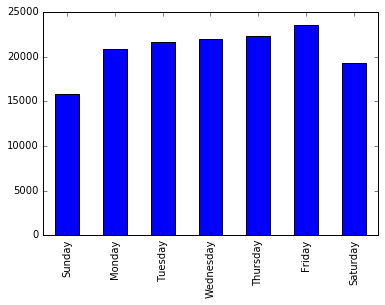

In [20]:
count_by_day_ss.plot(kind='bar')

There are differences, but are they significant?

In [21]:
expected_count_by_day_ss = pd.Series(count_by_day_ss.sum() / 7, 
                                  index=count_by_day_ss.index)
expected_count_by_day_ss

Sunday       20795.857143
Monday       20795.857143
Tuesday      20795.857143
Wednesday    20795.857143
Thursday     20795.857143
Friday       20795.857143
Saturday     20795.857143
dtype: float64

In [22]:
scipy.stats.chisquare(count_by_day_ss, expected_count_by_day_ss, axis=None)

Power_divergenceResult(statistic=1854.9813355682109, pvalue=0.0)

The *p* value of zero shows that this is a significant result, and that the varying number of accidents by day is significant.

### Activity 2
We might expect there to be more accidents in bad weather. We might also expect that weather conditions will affect different roads differently, with bad conditions on high-speed roads having more of an impact on accident likelihood than low-speed (typically urban) roads.

If the weather affects all roads equally, we would expect to see the proportions of accidents in different weathers to be the same for different road speed limits. 

Use a chi-squared test to determine if the proportion of accidents in different weather conditions is independent of road speed.

Note that this activity will require several stages, following the pattern above: finding the values for the different ranges of `Weather_Conditions`, extracting the data from the database into a DataFrame, calculating the expected values for each combination of speed limit and weather, and finally calculating the chi-squared *p* value.

The solution is in the [`14.3solutions`](14.3solutions.ipynb) Notebook.

In [ ]:
# Insert your solution here.

## What next?
If you are working through this Notebook as part of an inline exercise, return to the module materials now.

If you are working through this set of Notebooks as a whole, move on to `14.4 Regression on subgroups`.